In [2]:
from astropy.nddata import CCDData
import numpy as np
import matplotlib.pyplot as plt

from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import ApertureStats
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry
from astropy.io import fits
import ccdproc as ccdp
import astropy.units as u
import pandas as pd
from pathlib import Path
import os
from astropy.stats import mad_std
from astropy import modeling

from astroquery.simbad import Simbad
from astroquery.astrometry_net import AstrometryNet
from astropy.wcs import WCS
from astropy import coordinates

In [3]:
#name strings for fits files and csv files
fits = '.fits'
csv = '_stars.csv'

#filter specific file names
luminance = 'Light_Luminance_3.500_secs_001_reduced'
red = 'star_Light_Red_18_secs_001_reduced'
green = 'star_Light_Green_18_secs_001_reduced'
blue = 'star_Light_Blue_18_secs_001_reduced'

#set current filter
ref_image_name = luminance + fits
ref_csv_name = luminance + csv
current_filter = 'Luminance'

#define path for csv files to be written to
csv_path = Path(f'./RZ Cep/All_RZ_Cep/2023_11_10/RZ_Cep/CSVs/Unmatched Stars/{current_filter}')

#set the path to the images we are looking at
current_raw_path = f'./RZ Cep/All_RZ_Cep/2023_11_10/RZ_Cep/Lights/{current_filter} Reduced/'
#create a list of files in the directory (file) indicated by the path, just in case some sub folders exist or files that are
#not of the FITS type.
file_list = [f for f in os.listdir(current_raw_path) if f.endswith(".fits")]

#convert the path from a string into a Path object that can be put into functions
raw_path = Path(current_raw_path)
#read in the images
raw_ims = ccdp.ImageFileCollection(raw_path, filenames=file_list)

# Estimate Star Position, hence FWHM #

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


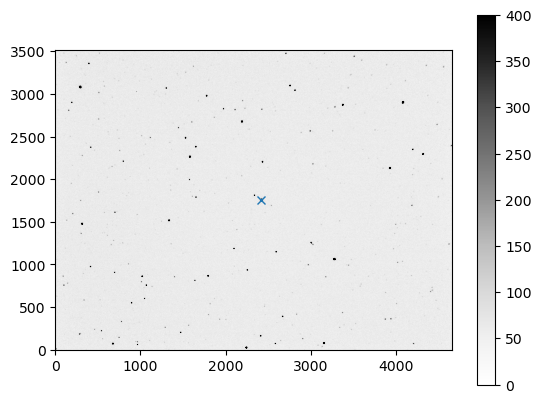

In [4]:
#read in raw image
raw_im = CCDData.read(raw_path / ref_image_name)

#plot the image, scaling it to see more of the stars
plt.imshow(raw_im.data, cmap='Greys', vmin=0, vmax=400)
plt.gca().invert_yaxis()
#plot an x to estimate star position
plt.plot(2410, 1760, marker='x')
plt.colorbar()
plt.show()

Text(0, 0.5, 'Recieved Counts (photons)')

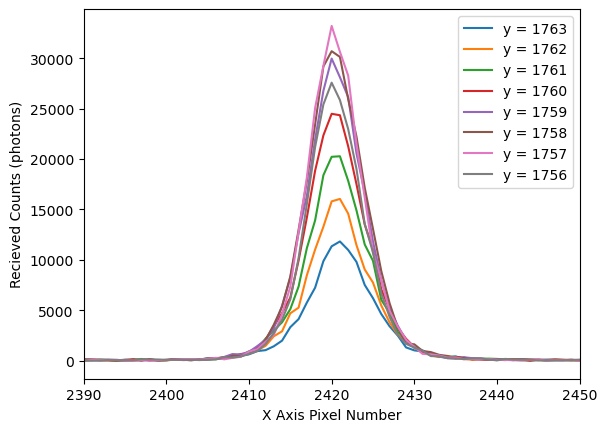

In [5]:
#plot a slice of the image at y = pix value
plt.plot(raw_im.data[1763], label='y = 1763')
plt.plot(raw_im.data[1762], label='y = 1762')
plt.plot(raw_im.data[1761], label='y = 1761')
plt.plot(raw_im.data[1760], label='y = 1760')
plt.plot(raw_im.data[1759], label='y = 1759')
plt.plot(raw_im.data[1758], label='y = 1758')
plt.plot(raw_im.data[1757], label='y = 1757')
plt.plot(raw_im.data[1756], label='y = 1756')
plt.legend()

y_peak_loc = 1757
y_peak_height = 34000
#peaks at y_pix = 1793 for 2022_12_07, so this is the approximate y location (height = 16000)
#peaks at y_pix = 1756 for 2023_01_23, so this is the approximate y location (height = 38000)

#find the rough location of the peak (range)
plt.xlim(2390, 2450)

plt.xlabel('X Axis Pixel Number')
plt.ylabel('Recieved Counts (photons)')

Text(0, 0.5, 'Recieved Counts (photons)')

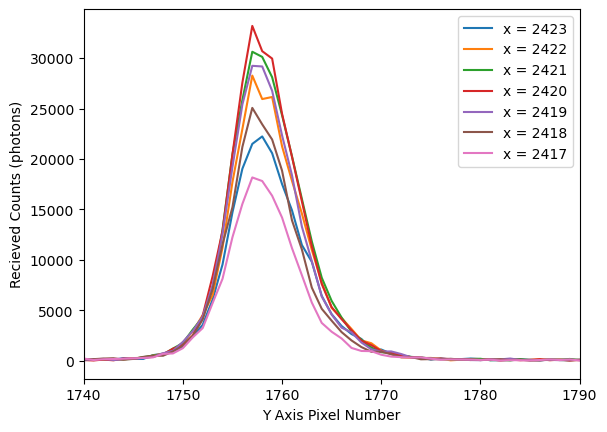

In [6]:
#plot a slice of the image across the x axis
plt.plot(raw_im.data[:, 2423], label='x = 2423')
plt.plot(raw_im.data[:, 2422], label='x = 2422')
plt.plot(raw_im.data[:, 2421], label='x = 2421')
plt.plot(raw_im.data[:, 2420], label='x = 2420')
plt.plot(raw_im.data[:, 2419], label='x = 2419')
plt.plot(raw_im.data[:, 2418], label='x = 2418')
plt.plot(raw_im.data[:, 2417], label='x = 2417')
plt.legend()

#if less iterations, initial guess was more accurate

x_peak_loc = 2420
x_peak_height = 34000
#peaks at x_pix = 2365 for 2022_12_07, so this is the approximate location (height = 16000)
#peaks at x_pix = 2371 for 2023_01_23, so this is the approximate location (height = 38000)

#find approximate peak location range
plt.xlim(1740, 1790)

plt.xlabel('Y Axis Pixel Number')
plt.ylabel('Recieved Counts (photons)')

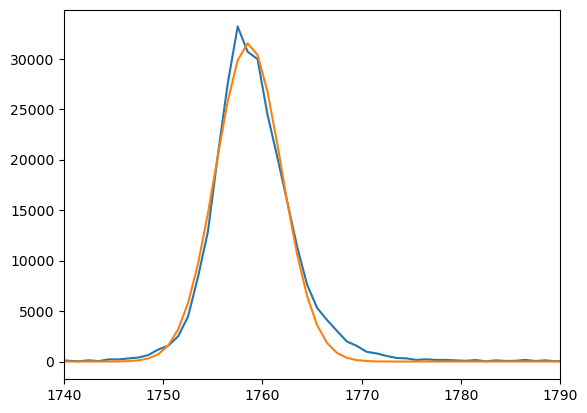

16641.883121606155
1762
10


In [7]:
#defined a fitter algorithm for fitting the Gaussian, in this case the Levenberg-Marquardt, which uses a least squares method
algorithm = modeling.fitting.LevMarLSQFitter()
#define Gaussian to fit, with test peak value, mean and standard deviation
#mean found from approx y location
model_y = modeling.models.Gaussian1D(y_peak_height, y_peak_loc, 3)

#define the x range of the data (AKA the number of pixels in the y direction)
x_range_y = np.linspace(0, len(raw_im.data[:, x_peak_loc]), len(raw_im.data[:, x_peak_loc]))
#apply the algortihm to the model, which fits the model to the data
gaussian_fit_y = algorithm(model_y, x_range_y, raw_im.data[:, x_peak_loc])

#plot original data and Gaussian curve to find new trial values
plt.plot(x_range_y, raw_im.data[:, x_peak_loc])
plt.plot(x_range_y, gaussian_fit_y(x_range_y))
plt.xlim(1740, 1790)
plt.show()

#find the half height of the gaussian
half_max_y = (np.max(raw_im.data[:, x_peak_loc]) - np.min(raw_im.data[:, x_peak_loc]))/2
print(half_max_y)

#find the closest data point and print its index (argmin returns the index)
closest_y = (np.abs(gaussian_fit_y(x_range_y)-half_max_y)).argmin()
print(closest_y)

#this is the full width half maximum of the star in y direction. 
FWHM_y = np.abs(closest_y - y_peak_loc) * 2
print(FWHM_y)

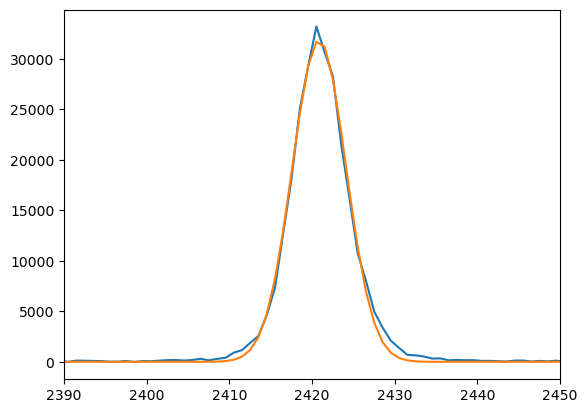

16628.814747743247
2424
8
9.0


In [8]:
#define Gaussian to fit, with test peak value, mean and standard deviation
#mean found from approx y location
model_x = modeling.models.Gaussian1D(x_peak_height, x_peak_loc, 3)

#define the x range of the data (AKA the number of pixels in the x direction)
x_range_x = np.linspace(0, len(raw_im.data[y_peak_loc]), len(raw_im.data[y_peak_loc]))
#apply the algortihm to the model, which fits the model to the data
gaussian_fit_x = algorithm(model_x, x_range_x, raw_im.data[y_peak_loc])

#plot original data and Gaussian curve to find new trial values
plt.plot(x_range_x, raw_im.data[y_peak_loc])
plt.plot(x_range_x, gaussian_fit_x(x_range_x))
plt.xlim(2390, 2450)
plt.show()

#find the half height of the gaussian
half_max_x = (np.max(raw_im.data[y_peak_loc]) - np.min(raw_im.data[y_peak_loc]))/2
print(half_max_x)

#find the closest data point and print its index (argmin returns the index)
closest_x = (np.abs(gaussian_fit_x(x_range_x)-half_max_x)).argmin()
print(closest_x)

#this is the full width half maximum of the star in x direction. 
FWHM_x = np.abs(closest_x - x_peak_loc) * 2
print(FWHM_x)
FWHM_trial = (FWHM_x + FWHM_y)/2
print(FWHM_trial)

# Perform Aperture Photometry on All Stars #

In [25]:
#for tracking how many files operations have been completed
i = 0

for light, file_name in raw_ims.ccds(imagetyp='Light Frame', ccd_kwargs={'unit':'adu'}, return_fname=True):
    '''setup'''
    #read in header to find the date and time the image was taken
    date_time = CCDData.read(raw_path / file_name).header['DATE-OBS']
    exptime = CCDData.read(raw_path / file_name).header['EXPTIME']
    #assume a starting fwhm similar to that of the original image
    FWHM = FWHM_trial
    #ensure we are working with only the image data
    light = light.data
    #find image stats of target image
    bkg_mean, bkg_median, bkg_std = sigma_clipped_stats(light, sigma=4, stdfunc=mad_std)
    #rename the files
    file_name = file_name.replace('.fits', '_stars')
    print('setup done')

    '''search for stars in the image'''
    #use DAOStarFinder algorithm to search for stars
    daofind = DAOStarFinder(fwhm=FWHM, threshold=5 * bkg_std, brightest=5)
    #subtract background median to reduce effect of background noise
    stars = daofind(light - bkg_median)
    
    del(daofind) #mem saving
    print('initial star search done')
    
    '''find an updated full-width-half-maximum'''
    #define new array of all star positions
    newstars = np.transpose((stars['xcentroid'], stars['ycentroid']))
    #define circular apertures for all star positions
    apertures = CircularAperture(newstars, r=FWHM*2)
    #use the apertures to find image specific fwhm
    '''bad nasty code line that means loop breaks unless median background is subtracted'''
    aperstats = ApertureStats(light-bkg_median, apertures)
    new_FWHM = aperstats.fwhm
    #aperstats outputs as a Quantity datatype, convert back to a number
    FWHM = float(np.median(new_FWHM) / (1 * u.pix))
    print('updated full-width-half-maximum')
    
    '''find stars again using new full-width-half-maximum'''
    #set up new star finder
    '''IMPORTANT: Images beyond the first few in 2023_01_23 have much less noise, possibly due to absent cloud cover. 
    The first few were the ones used in trials, so a lower threshold is needed to detect all stars than initially thought.'''
    '''In the 2022_12_07, a threshold of four doesn't detect enough stars in image 141'''
    daofind2 = DAOStarFinder(fwhm=FWHM, threshold=4*bkg_std, brightest=150)
    #subtract background median to reduce noise again
    stars2 = daofind2(light - bkg_median)
    #define new array of all star positions
    newstars2 = np.transpose((stars2['xcentroid'], stars2['ycentroid']))
    print('secondary search done')

    '''set up new apertures and annuli for aperture photometry'''
    #define radius of aperture
    r = FWHM * 3
    #define radius of annulus, so that it has the same area as the aperture
    r_a = (np.sqrt(8)/2 - 1) * r
    #define apertures and annuli
    apertures2 = CircularAperture(newstars2, r=r)
    annuli = CircularAnnulus(newstars2, r_in=r, r_out=r+r_a)
    print('apertures and annuli defined')
    
    '''test for saturation'''
    #define saturation level. factor is arbitrary and chosen by us, correcting for non linearity is 
    #beyond the scope of our projects
    sat_level = np.power(2, 16) * 0.8
    #set up aperture stats without background subtracted
    ap_stats = ApertureStats(light, apertures2)

    #test if pixels are saturated
    j = 0
    saturated = []
    while j < 150:
        if sat_level <= ap_stats.max[j]:
            print('star', j, 'is close to saturated')
            saturated.append(True)
            j += 1
        else:
            saturated.append(False)
            j += 1 
    print('tested for saturation')

    '''isolate useful image properties and perform aperture photometry for the rest'''
    #run aperturestats on annuli
    an_stats = ApertureStats(light, annuli)
    #perform aperture photometry with new apertures
    phot_table = aperture_photometry(light, apertures2)
    #extract recorded counts for the star
    counts = np.array(phot_table['aperture_sum'])
    #extract sky value of the annunli using their median and multiplying it by the total area of the aperture
    #more accurate background that is star specfic
    sky = an_stats.median * np.pi * (r ** 2)
    #correct the aperture photometry for the sky value, counts are now purely from star
    corr_counts = counts - sky
    #calculate flux using exposure time, set to 1 to correct for exposure time later
    flux = corr_counts / 1.0
    #calculate instrumental magnitude from flux
    inst_mag = -2.5 * np.log10(flux)
    #save sharpness and roundness from daostarfinder for histogram plotting purposes
    sharp = stars2['sharpness']
    round_ = stars2['roundness1']
    round__ = stars2['roundness2']
    #save aperturestats
    ellipticity = ap_stats.ellipticity
    #save errors
    counts_error = np.sqrt(corr_counts)
    flux_error = counts_error / 1.0
    mag_error = -2.5 / (flux_error * np.log(10))
    print('aperture photometry completed')
   
    '''write to a dataframe'''
    #set up dataframe of 200 star positions and flux read from aperture photometry
    x_center = np.transpose(stars2['xcentroid'])
    y_center = np.transpose(stars2['ycentroid'])
    annulus_bkg = sky
    counts_raw = counts
    FWHM_arr = np.full(150, FWHM)
    date_arr = [date_time] * 150
    exp_time = [exptime] * 150
    sky_corr_counts = corr_counts
    flux_calc = flux
    mag_calc = inst_mag
    print('dataframe info isolated')
   
    '''write to a csv file'''
    df = pd.DataFrame(data=(x_center, y_center, annulus_bkg, counts_raw, sky_corr_counts, counts_error, 
                            flux_calc, flux_error, mag_calc, mag_error, saturated, FWHM_arr, date_arr, 
                            exp_time, sharp, round_, round__, ellipticity))
    df = df.T
    df.columns = ['x_center', 'y_center', 'annulus_bkg', 'counts', 'sky_corrected_counts', 'counts_error', 
                  'flux', 'flux_error', 'instrumental_mag', 'mag_error', 'saturated?', 'FWHM', 'date_time', 'exp_time', 
                  'sharpness', 'roundness_sym', 'roundness_gauss', 'ellipticity']
    #write csv file contating positions and fluxes for that image
    df.to_csv(csv_path / f'{file_name}.csv')
    print('dataframe created')
    #track how many files have been through the loop
    i += 1
    print('csv file written, ', i, 'files completed')

print('all done!!!')

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done


C:\ProgramData\Anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  1 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  2 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  3 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  4 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  5 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  6 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  7 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  8 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  9 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  10 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  11 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  12 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  13 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  14 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  15 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  16 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  17 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  18 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  19 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  20 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  21 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  22 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  23 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  24 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  25 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  26 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  27 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  28 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  29 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  30 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  31 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  32 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  33 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  34 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  35 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  36 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  37 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  38 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  39 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  40 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  41 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  42 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  43 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  44 files completed


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  45 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


dataframe created
csv file written,  46 files completed


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
setup done
initial star search done
updated full-width-half-maximum
secondary search done
apertures and annuli defined
tested for saturation
aperture photometry completed
dataframe info isolated
dataframe created
csv file written,  47 files completed
all done!!!


C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:98: RuntimeWarning: invalid value encountered in log10
  inst_mag = -2.5 * np.log10(flux)
C:\Users\es2143\AppData\Local\Temp\ipykernel_14432\1967430804.py:106: RuntimeWarning: invalid value encountered in sqrt
  counts_error = np.sqrt(corr_counts)


# Assigning Star IDs to First Image (REF IM) #

In [9]:
#read in the original image and the csv associated with it
raw_im = CCDData.read(raw_path / ref_image_name)
df_ref = pd.read_csv(csv_path / ref_csv_name, delimiter=',')

#get all info Simbad has on our main star
#set up Simbad search
customSimbad = Simbad()
#add fields to output
customSimbad.add_votable_fields('otype','flux(U)','flux(B)','flux(V)','flux(R)','flux(I)','flux(G)','flux(J)','flux(H)',
                                'flux(K)','flux(u)','flux(g)','flux(r)','flux(i)','flux(z)','ra(deg)','dec(deg)','ids')

#search for object and its properties, saving to a dataframe
RZ_Cep = customSimbad.query_object('RZ Cep')
df_RZ_Cep = RZ_Cep.to_pandas()

#find star position in degrees
RZ_Cep_ra = df_RZ_Cep['RA_deg'][0]
RZ_Cep_dec = df_RZ_Cep['DEC_deg'][0]
print(RZ_Cep_ra, RZ_Cep_dec)

#set up Astrometry.net solver, which compares image to the sky to find exact sky position
ast = AstrometryNet()
ast.api_key = 'uktlwsvagbqfbbwl'

#define image size
image_width = raw_im.header['NAXIS1']
image_height = raw_im.header['NAXIS2']
print(image_width, image_height)

#use astrometry.net to match the image data to the sky and find correct coordinates 
wcs_header = ast.solve_from_source_list(df_ref['x_center'], df_ref['y_center'], #input star positions to be compared
                                        image_width, image_height, #image size for matching to the sky
                                        solve_timeout=180, #max time for the solving to be done in
                                        #scale_type='ul',
                                        scale_est = raw_im.header['SCALE'], #check header to see if scaling is required
                                        scale_err = 5, #estimate scale error
                                        #scale_lower = raw_im.header['SCALE'] * 0.9,
                                        #scale_upper = raw_im.header['SCALE'] * 1.1,
                                        scale_units = 'arcsecperpix', #units of scaling
                                        crpix_center=True, #force reference point to be centre of image
                                        center_ra = RZ_Cep_ra, #set image centre as star centre
                                        center_dec = RZ_Cep_dec, 
                                        radius = (raw_im.header['SCALE'] * image_width)/3600 #scale to arcseconds
                                       )

#convert extracted information into a world coordinate system for the image, which is added to the image header
w = WCS(wcs_header)
print(w)
raw_im.header.update(w.to_header(), 'relax')

#change reference point in header to sentre of star rather then image center
raw_im.header['CRPIX1'] = df_ref['x_center'][0]
raw_im.header['CRPIX2'] = df_ref['y_center'][0]

#convert pixel values to ra and dec
sky_all = w.pixel_to_world(df_ref['x_center'], df_ref['y_center'])
#append to original dataframe containing pixel position values, to be saved in csv file
df_ref['ra_from_astrometry_deg'] = sky_all.ra.degree
df_ref['dec_from_astrometry_deg'] = sky_all.dec.degree

#save all stars, their names, ra and dec, Simbad properties within a certain radius of the centre to a dataframe
#set up coordinates associated with 
c = coordinates.SkyCoord(sky_all)
#ensures all stars recieve their id, as a smaller radius means stars close to the edge of the image will not get a proper id
r = 5 * u.arcminute
result_table = customSimbad.query_region(c, radius=r)
df_results = result_table.to_pandas()

#add id to csv file and overwrite it
df_ref['star_id'] = df_results['MAIN_ID']
df_ref = df_ref.drop('Unnamed: 0', axis=1)
df_ref.to_csv(csv_path / ref_csv_name)

339.80490354369 64.85850316231
4656 3520
Solving.............

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 339.813406685  64.8717372936  
CRPIX : 2328.5  1760.5  
CD1_1 CD1_2  : -2.89808191261e-05  0.000131676669675  
CD2_1 CD2_2  : -0.00013167609606  -2.90088981388e-05  
NAXIS : 0  0


In [10]:
#print reference image dataframe to check it
df_ref

,x_center,y_center,annulus_bkg,counts,sky_corrected_counts,counts_error,flux,flux_error,instrumental_mag,mag_error,...,FWHM,date_time,exp_time,sharpness,roundness_sym,roundness_gauss,ellipticity,ra_from_astrometry_deg,dec_from_astrometry_deg,star_id
0,2420.411123,1758.007468,188515.973098,2.721009e+06,2.532493e+06,1591.380839,2.532493e+06,1591.380839,-16.008871,-0.000682,...,10.112447,2023-11-10T20:42:17.485,3.5,0.468297,0.080798,-0.031310,0.023644,339.806606,64.859546,V* RZ Cep
1,296.702264,3082.576373,192119.147592,1.419490e+06,1.227371e+06,1107.867664,1.227371e+06,1107.867664,-15.222439,-0.000980,...,10.112447,2023-11-10T20:42:17.485,3.5,0.590223,-0.018104,0.169105,0.075545,340.367195,65.099801,TYC 4273-435-1
2,3276.114633,1064.655562,171943.657012,1.113844e+06,9.419002e+05,970.515449,9.419002e+05,970.515449,-14.935012,-0.001119,...,10.112447,2023-11-10T20:42:17.485,3.5,0.424465,0.046136,-0.207206,0.026815,339.534353,64.766739,TYC 4273-1351-1
3,2243.931921,27.876896,174355.192938,7.035827e+05,5.292275e+05,727.480230,5.292275e+05,727.480230,-14.309106,-0.001492,...,10.112447,2023-11-10T20:42:17.485,3.5,0.569331,0.009217,-0.066880,0.024387,339.281204,64.932095,BD+64 1700
4,1581.984862,2267.786741,174704.949018,6.654489e+05,4.907440e+05,700.531192,4.907440e+05,700.531192,-14.227137,-0.001550,...,10.112447,2023-11-10T20:42:17.485,3.5,0.524539,0.078430,0.091668,0.010968,340.022579,64.955021,TYC 4273-876-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,3083.947292,55.526558,172814.552094,1.901339e+05,1.731930e+04,131.602808,1.731930e+04,131.602808,-10.596326,-0.008250,...,10.112447,2023-11-10T20:42:17.485,3.5,0.599479,0.160550,-0.063866,0.018450,339.234769,64.820523,2MASS J22375782+6453569
146,750.217813,2481.785779,183270.445972,1.980268e+05,1.475632e+04,121.475598,1.475632e+04,121.475598,-10.422445,-0.008938,...,10.112447,2023-11-10T20:42:17.485,3.5,0.410410,-0.078108,0.090290,0.016444,340.147420,65.058118,UCAC4 775-051528
147,578.455169,3095.354248,189093.228666,2.029392e+05,1.384601e+04,117.669066,1.384601e+04,117.669066,-10.353312,-0.009227,...,10.112447,2023-11-10T20:42:17.485,3.5,0.950039,-0.219154,-0.037286,0.037496,340.351032,65.062390,TYC 4273-319-1
148,3336.063926,1514.494288,170087.420930,1.898472e+05,1.975974e+04,140.569329,1.975974e+04,140.569329,-10.739453,-0.007724,...,10.112447,2023-11-10T20:42:17.485,3.5,0.540916,0.098205,0.099261,0.009680,339.669293,64.745971,UCAC4 775-051528


# Histograms #

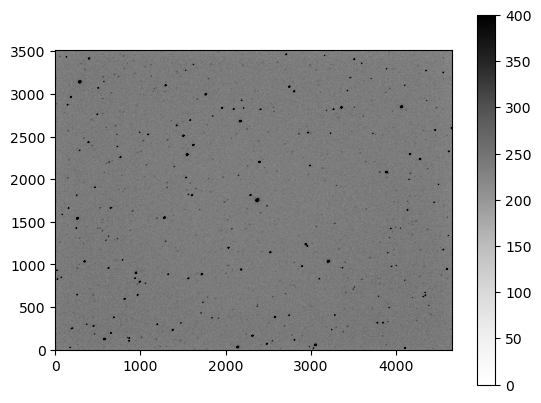

In [16]:
#read in raw image
raw_im = CCDData.read('./RZ Cep/2023_1_23/Photometry Practise/star_Light_Luminance_10_secs_001_reduced.fits')


'''important: images beyond the first few have much less noise, possibly due to absent cloud cover. A lower threshold is needed to detect 200 stars'''
#plot the image, scaling it to see more of the stars
plt.imshow(raw_im.data, cmap='Greys', vmin=0, vmax=400)
#apertures2.plot(color='blue', lw=1.5, alpha=0.5)
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [4]:
df = pd.read_csv(file_path / 'star_Light_Luminance_10_secs_078_reduced_stars.csv')
df

,Unnamed: 0,x_center,y_center,annulus_bkg,counts,sky_corrected_counts,flux,instrumental_mag,saturated?,FWHM,date_time,exp_time,sharpness,roundness_sym,roundness_gauss,ellipticity
0,0,2309.535543,1704.991636,647887.665814,3.232790e+06,2.584902e+06,2.584902e+06,-16.031110,False,12.110281,2023-01-24T00:03:48.297,10.0,0.517936,0.619844,-0.117763,0.058455
1,1,3136.553381,980.926520,621284.500832,2.149854e+06,1.528569e+06,1.528569e+06,-15.460713,False,12.110281,2023-01-24T00:03:48.297,10.0,0.531262,0.501945,-0.120968,0.041958
2,2,239.715322,3108.732048,624643.350874,2.579487e+06,1.954844e+06,1.954844e+06,-15.727780,False,12.110281,2023-01-24T00:03:48.297,10.0,0.452084,0.555872,-0.213747,0.046090
3,3,4009.701420,2787.602685,622707.014263,1.729840e+06,1.107133e+06,1.107133e+06,-15.110499,False,12.110281,2023-01-24T00:03:48.297,10.0,0.476532,0.578983,-0.321578,0.047852
4,4,2976.724274,2.881491,621388.244406,7.851970e+05,1.638088e+05,1.638088e+05,-13.035843,False,12.110281,2023-01-24T00:03:48.297,10.0,0.480175,0.071531,-0.432656,0.243338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,3736.711535,714.815466,631864.837546,6.441129e+05,1.224801e+04,1.224801e+04,-10.220164,False,12.110281,2023-01-24T00:03:48.297,10.0,0.570352,0.265401,-0.326735,0.009561
196,196,459.733969,1390.180651,645711.732847,6.685942e+05,2.288245e+04,2.288245e+04,-10.898756,False,12.110281,2023-01-24T00:03:48.297,10.0,0.356612,0.650537,0.241224,0.022457
197,197,1595.959988,94.476676,617182.795302,6.419797e+05,2.479693e+04,2.479693e+04,-10.985995,False,12.110281,2023-01-24T00:03:48.297,10.0,0.931370,0.704115,0.088685,0.005261
198,198,3558.936127,2682.291828,606804.855180,6.410578e+05,3.425291e+04,3.425291e+04,-11.336744,False,12.110281,2023-01-24T00:03:48.297,10.0,0.425566,0.644790,-0.185644,0.006092


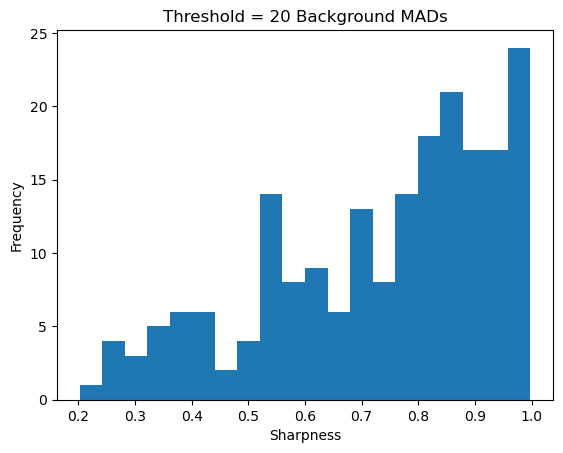

In [5]:
n_bins = 20
plt.hist(df['sharpness'], bins=n_bins)
plt.xlabel('Sharpness')
plt.ylabel('Frequency')
plt.title('Threshold = 20 Background MADs')
plt.show()
#ratio of difference between highest pixel value and mean of surrounding pixels

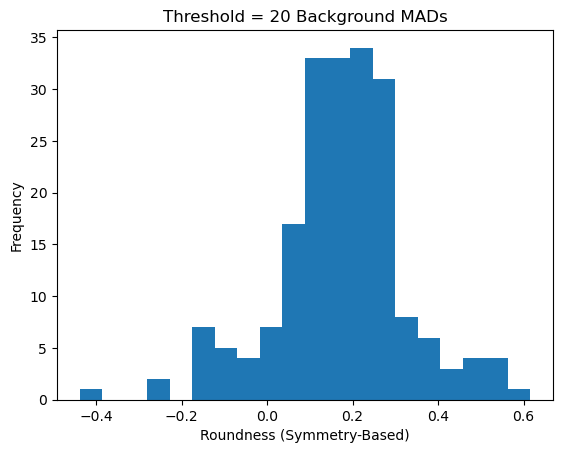

In [6]:
n_bins = 20
plt.hist(df['roundness_sym'], bins=n_bins)
plt.xlabel('Roundness (Symmetry-Based)')
plt.ylabel('Frequency')
plt.title('Threshold = 20 Background MADs')
plt.show()
#circular has 0 roundness, negative roundness is extended in x, positive extended in y

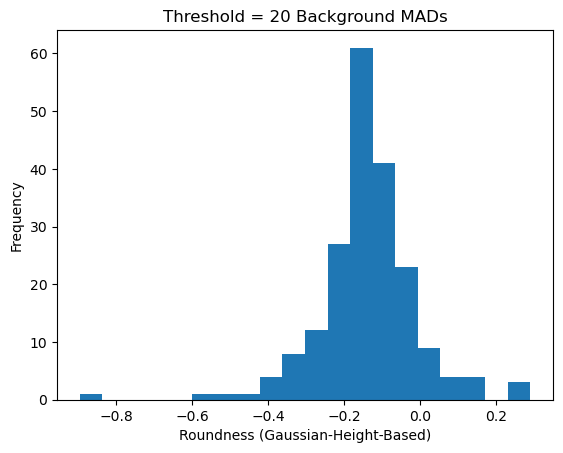

In [7]:
n_bins = 20
plt.hist(df['roundness_gauss'], bins=n_bins)
plt.xlabel('Roundness (Gaussian-Height-Based)')
plt.ylabel('Frequency')
plt.title('Threshold = 20 Background MADs')
plt.show()
#calculated using height difference of Gaussians in x and y direction

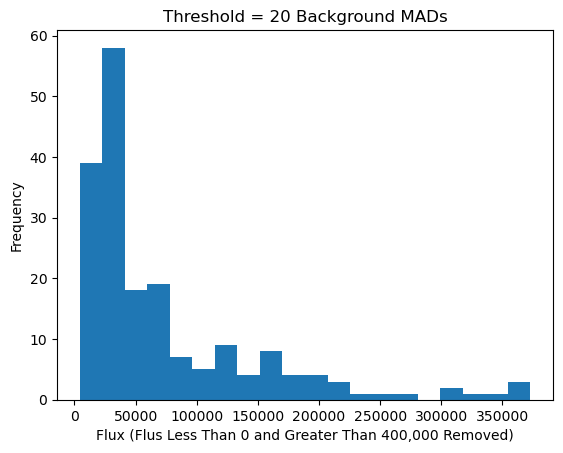

In [8]:
n_bins = 20
#remove outliers
i = 0
flux_plot = []
while i < 200:
    if df['flux'][i] < 0:
        i += 1
    elif df['flux'][i] > 4e5:
        i += 1
    else:
        flux_plot.append(df['flux'][i])
        i += 1

plt.hist(flux_plot, bins=n_bins)
plt.xlabel('Flux (Flus Less Than 0 and Greater Than 400,000 Removed)')
plt.ylabel('Frequency')
plt.title('Threshold = 20 Background MADs')
plt.show()
#calculated from aperture photometry

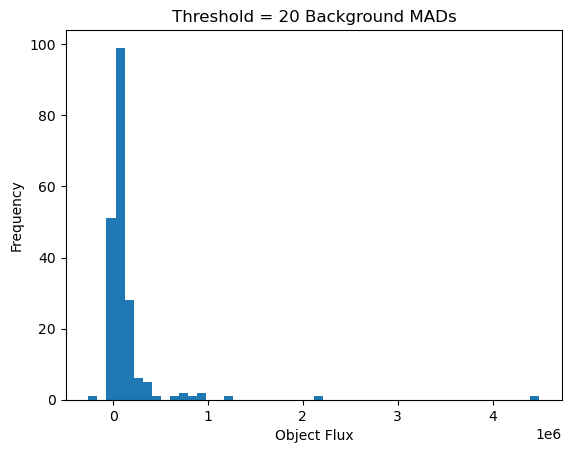

In [9]:
n_bins = 50
plt.hist(df['flux'], bins=n_bins)
plt.xlabel('Object Flux')
plt.ylabel('Frequency')
plt.title('Threshold = 20 Background MADs')
plt.show()

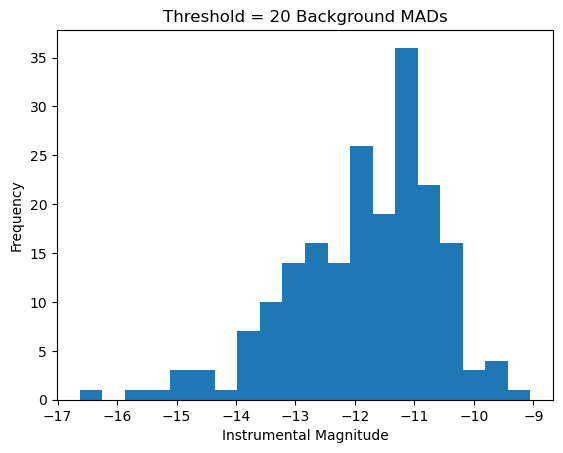

In [10]:
n_bins = 20
plt.hist(df['instrumental_mag'], bins=n_bins)
plt.xlabel('Instrumental Magnitude')
plt.ylabel('Frequency')
plt.title('Threshold = 20 Background MADs')
plt.show()